## Train Model

Loading data from disk...
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training starting.
Epoch 1/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8777 - loss: 0.2801 - recall: 0.8833

2003/2003 ━━━━━━━━━━━━━━━━━━━━ 590s 264ms/step - accuracy: 0.8777 - loss: 0.2801 - recall: 0.8834 - val_accuracy: 0.8641 - val_loss: 0.3814 - val_recall: 0.7951 - learning_rate: 1.0000e-04
Epoch 2/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 195s 83ms/step - accuracy: 0.9562 - loss: 0.1139 - recall: 0.9571 - val_accuracy: 0.8671 - val_loss: 0.5402 - val_recall: 0.7991 - learning_rate: 1.0000e-04
Epoch 3/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.9686 - loss: 0.0853 - recall: 0.9702 - val_accuracy: 0.9003 - val_loss: 0.4313 - val_recall: 0.8300 - learning_rate: 1.0000e-04
Epoch 4/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9686 - loss: 0.0844 - recall: 0.9684

2003/2003 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - accuracy: 0.9686 - loss: 0.0844 - recall: 0.9684 - val_accuracy: 0.8945 - val_loss: 0.3649 - val_recall: 0.9358 - learning_rate: 1.0000e-04
Epoch 5/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.9728 - loss: 0.0767 - recall: 0.9746 - val_accuracy: 0.8526 - val_loss: 0.5348 - val_recall: 0.8111 - learning_rate: 1.0000e-04
Epoch 6/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 139s 70ms/step - accuracy: 0.9763 - loss: 0.0637 - recall: 0.9780 - val_accuracy: 0.8622 - val_loss: 0.5738 - val_recall: 0.7872 - learning_rate: 1.0000e-04
Epoch 7/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9788 - loss: 0.0658 - recall: 0.9810
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.9788 - loss: 0.0658 - recall: 0.9810 - val_accuracy: 0.8677 - val_loss: 0.5850 - val_recall: 0.8086 - learning_rate: 1.0000e-04
Epoch 8/30
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 1

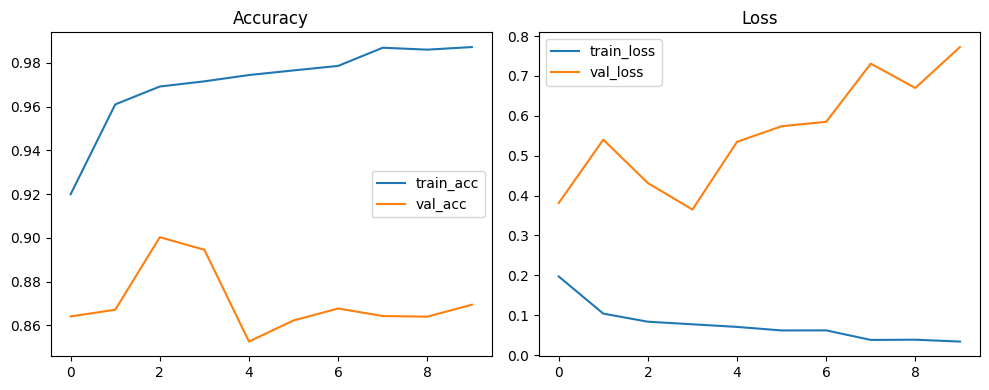

Model saved to /content/drive/MyDrive/Final Year Project/Battery_DL_Dataset


In [1]:
# convlstm_training_and_evaluation_updated.py
# Updated training and evaluation scripts with training curves plotting

# ------------------
# 1. TRAINING
# ------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

# --- 1. SYSTEM CONFIG ---
SAVE = r"/content/drive/MyDrive/Final Year Project/Battery_DL_Dataset"
BATCH_SIZE = 8
EPOCHS = 30

# --- 2. LOAD DATA (RAM-Safe Mode) ---
print("Loading data from disk...")
X_train = np.load(os.path.join(SAVE, "X_train.npy"), mmap_mode='r')
y_train = np.load(os.path.join(SAVE, "y_train.npy"), mmap_mode='r')
X_val = np.load(os.path.join(SAVE, "X_val.npy"), mmap_mode='r')
y_val = np.load(os.path.join(SAVE, "y_val.npy"), mmap_mode='r')

# --- 3. DATA GENERATOR (Smooth Feeding) ---
def data_generator(X, y, batch_size):
    indices = np.arange(len(X))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(X), batch_size):
            batch_indices = indices[i:i+batch_size]
            yield np.array(X[batch_indices]), np.array(y[batch_indices])

# --- 4. THE ARCHITECTURE (ConvLSTM) ---
inputs = Input(shape=(8, 96, 96, 3))

base = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3),
    alpha=0.75
)
base.trainable = False

x = TimeDistributed(base)(inputs)

x = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.2
)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# --- 5. CALLBACKS ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(SAVE, "best_battery_checkpoint_convlstm.h5"),
        monitor='val_loss',
        save_best_only=True
    )
]

# --- 6. TRAINING + CAPTURE HISTORY ---
print("Training starting.")
try:
    history = model.fit(
        data_generator(X_train, y_train, BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=data_generator(X_val, y_val, BATCH_SIZE),
        validation_steps=len(X_val) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )
except KeyboardInterrupt:
    print("\nTraining manually stopped. Best weights should be restored by EarlyStopping if triggered.")

# --- 7. PLOT TRAINING CURVES (place immediately after fit) ---
if 'history' in locals():
    hist = history.history
    # save history arrays for later reuse
    np.savez(os.path.join(SAVE, 'training_history_convlstm.npz'),
             train_acc=np.array(hist.get('accuracy', [])),
             val_acc=np.array(hist.get('val_accuracy', [])),
             train_loss=np.array(hist.get('loss', [])),
             val_loss=np.array(hist.get('val_loss', [])))

    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.get('accuracy', []), label='train_acc')
    plt.plot(hist.get('val_accuracy', []), label='val_acc')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.get('loss', []), label='train_loss')
    plt.plot(hist.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.legend()

    save_plot = os.path.join(SAVE, 'training_history_convlstm.png')
    plt.tight_layout()
    plt.savefig(save_plot)
    print(f"Training plot saved to {save_plot}")
    plt.show()
else:
    print("No training history available to plot.")

# --- 8. FINAL SAVE ---
model.save(os.path.join(SAVE, "battery_model_final_convlstm.h5"))
print(f"Model saved to {SAVE}")

## Evaluation

Loading model: battery_model_final_convlstm.h5...


Model loaded successfully.
Loading validation data...
Showing training curves from: /content/drive/MyDrive/Final Year Project/Battery_DL_Dataset/training_history_convlstm.png


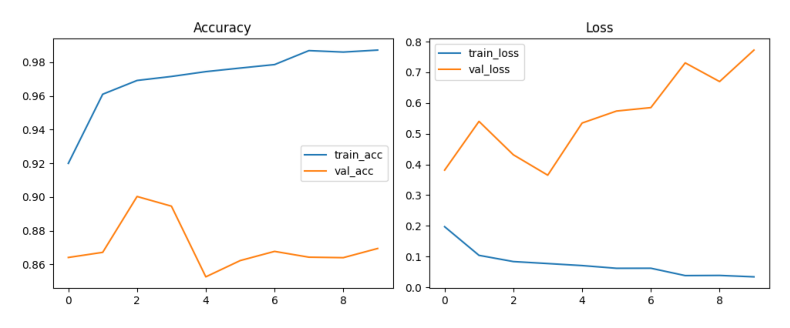

Generating predictions...
436/436 ━━━━━━━━━━━━━━━━━━━━ 71s 95ms/step

--- FINAL CLASSIFICATION REPORT (ConvLSTM) ---
                 precision    recall  f1-score   support

           Safe       0.93      0.85      0.89      1725
Thermal Runaway       0.87      0.94      0.90      1760

       accuracy                           0.90      3485
      macro avg       0.90      0.90      0.90      3485
   weighted avg       0.90      0.90      0.90      3485

Confusion Matrix saved as 'confusion_matrix_convlstm_proof.png'


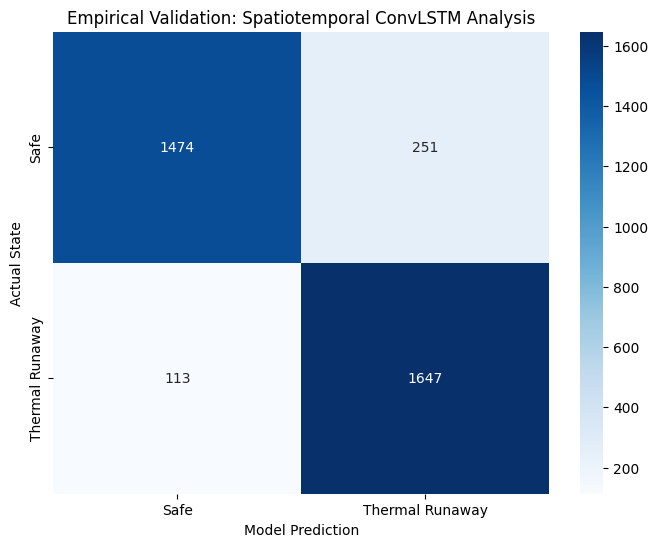

In [3]:
# ------------------
# 2. EVALUATION
# ------------------
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import numpy as np

# 1. SET PATHS
SAVE_PATH = r"/content/drive/MyDrive/Final Year Project/Battery_DL_Dataset"
MODEL_NAME = "battery_model_final_convlstm.h5"

# 2. LOAD MODEL AND DATA
print(f"Loading model: {MODEL_NAME}...")
model = tf.keras.models.load_model(os.path.join(SAVE_PATH, MODEL_NAME))
print("Model loaded successfully.")

print("Loading validation data...")
X_val = np.load(os.path.join(SAVE_PATH, "X_val.npy"))
y_val = np.load(os.path.join(SAVE_PATH, "y_val.npy"))

# 3. SHOW TRAINING PLOT IF AVAILABLE
training_plot_path = os.path.join(SAVE_PATH, 'training_history_convlstm.png')
if os.path.exists(training_plot_path):
    print(f"Showing training curves from: {training_plot_path}")
    img = plt.imread(training_plot_path)
    plt.figure(figsize=(10,4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    # if png not found try npz
    npz_path = os.path.join(SAVE_PATH, 'training_history_convlstm.npz')
    if os.path.exists(npz_path):
        arr = np.load(npz_path)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(arr['train_acc'], label='train_acc')
        plt.plot(arr['val_acc'], label='val_acc')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(arr['train_loss'], label='train_loss')
        plt.plot(arr['val_loss'], label='val_loss')
        plt.title('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('No saved training curves found. Run training script or check SAVE path.')

# 4. GENERATE PREDICTIONS
print("Generating predictions...")
y_pred_probs = model.predict(X_val, batch_size=8)
y_pred = (y_pred_probs > 0.5).astype(int)

# 5. PRINT REPORT
print("\n--- FINAL CLASSIFICATION REPORT (ConvLSTM) ---")
print(classification_report(y_val, y_pred, target_names=['Safe', 'Thermal Runaway']))

# 6. PLOT CONFUSION MATRIX
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Thermal Runaway'],
            yticklabels=['Safe', 'Thermal Runaway'])
plt.title('Empirical Validation: Spatiotemporal ConvLSTM Analysis')
plt.ylabel('Actual State')
plt.xlabel('Model Prediction')
save_file = 'confusion_matrix_convlstm_proof.png'
plt.savefig(save_file)
print(f"Confusion Matrix saved as '{save_file}'")
plt.show()